# Portfolio Strategy - Baseline Model

We will implement three portfolio strategies:

1. Shotgun then Prune
2. Prune Losers; Reinvest in Winners
3. Prune Losers; Reinvest in Winners and Newbies

<u>Strategy One - Shotgun then Prune </u>

**First sampling period (3-1-2009 to 12-31-2010)**

Divide cash (e.g. $10 million) evenly into N_1 (e.g. 100) tickers. Tickers are selected though random selection from an unranked prospect list from the Baseline Algorithm.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Check tickers in the portfolio against the new prospect list. A ticker that is still on the list is considered a "winner". Tickers not on the list are "Losers" and are liquidated to raise cash. 

We repeat this process until the last sampling period (3-1-2009 to 12-31-2018).

**Final Tally** 

Tally up the investment gain by calculating the value of the portfolio (cash + stocks) on 3-31-2019.


<u>Strategy Two - Prune Losers; Reinvest in Winners</u>

**First sampling period (3-1-2009 to 12-31-2010)**

Same as Strategy One.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Cash raised by selling the Losers is reinvested evenly into the Winners.


<u>Strategy Three - Prune Losers; Reinvest in Winners and Newbies</u>

**First sampling period (3-1-2009 to 12-31-2010)**

Same as Strategy One.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Cash raised by selling the Losers is invested in new tickers selected from the new prospect list. Investment per ticker is the lesser of Available_Cash/N_new or 1e7/N_2, where N_new is the number of new tickers and N_2 is the number of tickers in the 2nd sampling period (e.g. 90).

If there is still cash left over after investing in these new tickers, it is reinvested evenly into the Winners.

<u>Benchmark against S&P (Jan 2011 - Mar 2019)</u>

The cumulative returns of these strategies are compared against the following S&P 500 returns over the period of Jan 2011 - Mar 2019:

* Total S&P 500 Return -	118.613%
* Annualized S&P 500 Return - 10.051%
* Total S&P 500 Return (Dividends Reinvested)	- 157.353%
* Annualized S&P 500 Return (Dividends Reinvested) - 12.271%


In [1]:
import quandl  # Access to Sharadar Core US Equities Bundle
api_key = '7B87ndLPJbCDzpNHosH3'

import math
import platform

from pylab import rcParams
import numpy as np
from sklearn import linear_model  # package for logistic regression (not using GPU)
import torch
import pandas as pd
from IPython.display import display
import time
import pickle
import random

from utils import *

from datetime import date, datetime, time, timedelta

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))

Python version:  3.6.6
Pytorch version: 1.1.0


## Import Stock Price History

In [3]:
stockprices = pd.read_csv("../datasets/sharader/stock_price_history.cvs")
prices = stockprices.set_index('date')

In [4]:
# Files containing active tickers in the sampling periods
predict_filenames = ['predicts_lin_int_12-31-2010.csv',
              'predicts_lin_int_12-31-2011.csv',
              'predicts_lin_int_12-31-2012.csv',
              'predicts_lin_int_12-31-2013.csv',
              'predicts_lin_int_12-31-2014.csv',
              'predicts_lin_int_12-31-2015.csv',
              'predicts_lin_int_12-31-2016.csv',
              'predicts_lin_int_12-31-2017.csv',
              'predicts_lin_int_12-31-2018.csv'
             ]

# End of sampling period
sampling_end_dates = [
    '2010-12-31',
    '2011-12-30',
    '2012-12-31',
    '2013-12-31',
    '2014-12-31',
    '2015-12-31',
    '2016-12-30',
    '2017-12-29',    
    '2018-12-31'
]

# First January following end of sampling period when portfolio is rebalanced (bought and sold)
rebalance_periods = [
    ('2011-01-03','2011-01-31'),
    ('2012-01-03','2012-01-31'),
    ('2013-01-02','2013-01-31'),
    ('2014-01-02','2014-01-31'),
    ('2015-01-02','2015-01-31'),
    ('2016-01-04','2016-01-31'),
    ('2017-01-03','2017-01-31'),
    ('2018-01-02','2018-01-31'),
    ('2019-01-02','2019-01-31')
]

# End of sampling periods
end_dates = [
    '2010-12-31',
    '2011-12-30',
    '2012-12-31',
    '2013-12-31',
    '2014-12-31',
    '2015-12-31',
    '2016-12-30',
    '2017-12-29',    
    '2018-12-31'
]

# For Strategy One, only the first item is used
portfolio_sizes = [
    100,
    90,
    80,
    70,
    60,
    50,
    40,
    30,
    20
]

START = 1e7 # Start the portfolio with $10M

# the date where the final value of the portfolio is tallied
target_date = '2019-03-29'  

## Import Prospect Lists (Baseline Linear Interpolation)

In [ ]:
prospects = {}

for date, predict_filename, rebalance_period in zip(sampling_end_dates, predict_filenames, rebalance_periods):
    
    # Get prospect lists for 10 Baggers
    predicts = pd.read_csv("../datasets/sharader/"+predict_filename, index_col=0).set_index('ticker')
    prospects[date] = predicts[predicts['10bagger'] == True]
    
    display(prospects[date])
    
    for ticker in prospects[date].index:
        
        # Determine if ticker has delisted during buy period (First Jan following end of sampling period)
        start, end = rebalance_period
        delist = prices[ticker].loc[start:end].isnull().values.any()
        
        # Remove delisted ticker from prospect list
        if delist:
            print('Remove delist: {}'.format(ticker))
            prospects[date] = prospects[date].drop(index=ticker)
    

In [7]:
prospects['2018-12-31']

,appreciation,10bagger
ticker,,
AAL,13.300752,True
AAPL,12.845540,True
AAXN,12.397788,True
ABG,25.096510,True
ABMD,55.413601,True
...,...,...
WLK,11.500578,True
WNS,11.723294,True
WYND,11.455639,True


## Useful Functions

In [8]:
def random_select(prospects, num_tickers, invalids=[]):
    # Randomly pick a number of valid tickers from prospect_list
   
    if (len(prospects)-len(invalids)) < num_tickers:
        print('Not enough tickers in prospect list!')
        selections = None
    else:
        selections = []
        num = 0
        while num < num_tickers:
            ticker = random.sample(prospects, 1)  # pick a ticker
            if not (ticker[0] in invalids+selections):
                # print(ticker[0])
                # print(invalids+selections)
                selections.append(ticker[0])  # add to select if ticker is valid and has not been picked already
                num += 1
    return selections

def average_price(ticker, start, end):
    # Calculate average price of a ticker in period between start and end
    # The function assumes there is a global dataset "prices"
    
    # get the ticker's prices in the period (drop the NaNs)
    prices_history = list(prices[ticker].loc[start:end].dropna())   
    
    return sum(prices_history)/len(prices_history)

def liquidate(tickers, holdings, start, end, debug=False):
    # Liquidate holding in period between start and end
    # The function assumes there is a global dataset "prices"

    total = 0
    price_list = []
    
    for ticker in tickers:
        if math.isnan(prices[ticker].loc[start]):
            # If stock has been delisted before rebalance period, get price at date of delist
            delist_price = prices[ticker].loc[prices[ticker].last_valid_index()] 
            price_list.append(delist_price)
        else:
            price_list.append(average_price(ticker, start, end)) 
   
    for ticker, num_shares, price in zip(tickers, holdings, price_list):
        if debug:
            print("{}: Liquidate {:.1f} sh at ${:.2f}".format(ticker, num_shares, price))
        total += num_shares * price
        
    return total

def invest_evenly(tickers, holdings, cash, start, end, debug=False):
    # Invest the cash evenly between the tickers over the rebalancing period (defined by start and end). 
    # Return updated holding as a list. 
    
    new_holdings = []
    
    for ticker, holding in zip(tickers, holdings):

        buy_price = average_price(ticker, start, end) # find average price during rebalance period
        shares_added = cash/buy_price   # calculate and save number of shares bought
        new_holdings.append(holding + shares_added)

        if debug:
            print("{}: Buy {:.1f} sh at ${:.2f}".format(ticker, shares_added, buy_price))
    
    return new_holdings
    

def portfolio_value(tickers, holdings, date, debug=False):
    # Value of portfolio on a specific date
    # The function assumes there is a global dataset "prices"
    
    # print('Calculate value of stock holdings on {}:'.format(date))

    total = 0
    price_list = []
    
    for ticker in tickers:
        if math.isnan(prices[ticker].loc[date]):
            # If stock has been delisted before rebalance period, get price at date of delist
            delist_price = prices[ticker].loc[prices[ticker].last_valid_index()] 
            price_list.append(delist_price)
        else:
            price_list.append(prices[ticker].loc[date]) 
   
    for ticker, num_shares, price in zip(tickers, holdings, price_list):
        if debug:
            print("{}: {:.1f} sh at ${:.2f}".format(ticker, num_shares, price))
        total += num_shares * price
        
    return total

def identify_winners(tickers, prospects):
    # If a ticker in the portfolio is in the prospect list, identify it as a winner.
    
    winners = []
    losers = []
    
    for ticker in tickers:
        if ticker in prospects:
            winners.append(ticker)
        else:
            losers.append(ticker)
    
    return winners, losers

def prune_losers(portfolio, tickers, debug=False):
    # Take the input portfolio and prune away the losers
    loser_tickers = []
    loser_holdings = []
    new_portfolio = {}
    new_portfolio['tickers']=[]
    new_portfolio['num_shares']=[]
    
    for ticker, num_shares in zip(portfolio['tickers'], portfolio['num_shares']):
        if ticker in tickers:
            if debug:
                print('Loser: {}sh of {}'.format(num_shares, ticker))
            # Sell the losers
            loser_tickers.append(ticker)
            loser_holdings.append(num_shares) 
        else:
            # keep the winners
            if debug:
                print('Winner: {}sh of {}'.format(num_shares, ticker))
            new_portfolio['tickers'].append(ticker)
            new_portfolio['num_shares'].append(num_shares) 
            
    return new_portfolio, loser_tickers, loser_holdings

# Implement Strategy One (Shotgun then Prune)

In [ ]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy One 

    portfolio = {}
    last = None   # to save the last portfolio
    start_cash = START  # Start with $10M

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):
        
        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Create the portfolio for the first time

            if debug:
                print("Shotgun!")

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(list(prospects[date].index), num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date].copy()   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Prune portfolio - Keep only the Winners

            if debug:
                print("Prune!")

            portfolio[date] = {}
            loser_tickers = []
            loser_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], list(prospects[date].index))
            portfolio[date],loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

            # Liquidate Losers for cash during rebalance period
            liquidation = liquidate(loser_tickers, loser_holdings, start, end, debug=debug)
            cash += liquidation

            if debug:
                print('Winners: {}'.format(winners))
                print('Losers: {}'.format(losers))
                print('Cash harvested from Losers: ${:.2f}'.format(liquidation))   
                print('\n')

            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')
    
        
    

Strategy One Return - mean:23.8%, std:25.4%


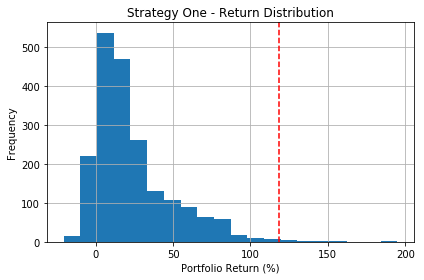

In [36]:
import statistics

print ("Strategy One Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(6, 4))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy One - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

# plt.xlim(left=-100, right=1000)

plt.show()

# Implement Strategy Two - Prune Losers & Reinvest in Winners

In [ ]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy Two 

    portfolio = {}  # for storing portfolio info
    last = None   # to save a copy of the portfolio prior to rebalancing
    cash = START  # Start with $10M in cash

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):

        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Build the portfolio by investing starter cash evenly in a number of tickers

            if debug:
                print("Invest Evenly into {} tickers!".format(num_tickers))

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(list(prospects[date].index), num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date]   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Rebalance portfolio - Let Winners run, Cut Losers Loose

            if debug:
                print("Let Winners run!")

            portfolio[date] = {}
            new_portfolio = {}
            loser_tickers = []
            loser_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], list(prospects[date].index))
            
            if len(losers) is not 0:  # if there are losers
                
                # create new portfolio by pruning the losers
                new_portfolio, loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

                # Liquidate Losers for cash during rebalance period
                liquidation = liquidate(loser_tickers, loser_holdings, start, end, debug=debug)
                cash += liquidation
            else:
                new_portfolio = last  # no change to the portfolio
            
            if debug:
                print('Winners: {}'.format(winners))
                print('Losers: {}'.format(losers))
                print('Cash harvested from Losers: ${:.2f}'.format(liquidation))   

           
            if cash > 0 and len(new_portfolio['tickers']) > 0:
                # If there is cash left over and there are winners left, invest it evenly into the winners
                
                num_winners = len(new_portfolio['tickers'])
                if debug:
                    print("Invest ${:.2f} into {} Winners!".format(cash, num_winners))

                # Invest cash evenly between the tickers
                invest = cash/num_winners  
                new_portfolio['num_shares'] = invest_evenly(new_portfolio['tickers'], \
                                                             new_portfolio['num_shares'], \
                                                             invest, start, end, debug=debug)
                cash = 0  # No more cash left

            # Merge Newbies and Winners into final portfolio        
            # portfolio[date]['tickers'] = winner_tickers + newbie_tickers
            # portfolio[date]['num_shares'] = winner_holdings + newbie_holdings
            portfolio[date] = new_portfolio
            
            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')

Strategy Two Return - mean:85.4%, std:102.7%


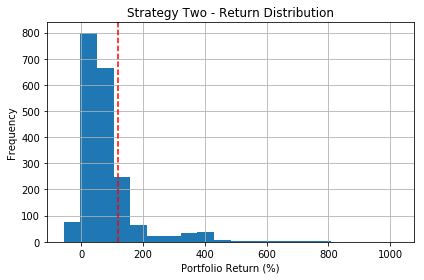

In [38]:
import statistics

print ("Strategy Two Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(6, 4))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy Two - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

# plt.xlim(left=-100, right=700)

plt.show()

# Strategy Three - Prune Losers; Reinvest in Winners and Newbies

In [ ]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy Three 

    portfolio = {}  # for storing portfolio info
    last = None   # to save a copy of the portfolio prior to rebalancing
    cash = START  # Start with $10M in cash

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):

        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Build the portfolio by investing starter cash evenly in a number of tickers

            if debug:
                print("Invest Evenly into {} tickers!".format(num_tickers))

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(list(prospects[date].index), num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date]   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Rebalance portfolio - Let Winners run, Cut Losers Loose

            if debug:
                print("Let Winners run!")

            portfolio[date] = {}
            new_portfolio = {}
            loser_tickers = []
            loser_holdings = []
            newbie_tickers = []
            newbie_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], list(prospects[date].index))
            
            if len(losers) is 0:  # if there are no losers
                new_portfolio = last  # no change to the portfolio
                if debug:
                    print('No change to Portfolio.')
                    print('Winners: {}'.format(winners))
            else:    
                # create new portfolio by pruning the losers
                new_portfolio, loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

                # Liquidate Losers for cash during rebalance period
                cash += liquidate(loser_tickers, loser_holdings, start, end, debug=debug)

                if debug:
                    print('Winners: {}'.format(winners))
                    print('Losers: {}'.format(losers))
                    print('Cash harvested from Losers: ${:.2f}'.format(cash))    
          
                if len(winners) >= num_tickers:
                    # If number of winners exceed the target ticker numbers
                    # Skip investing into newbies, cash will be reinvested into Winners
                    if debug:
                        print("{} Winners. No need for new prospects!".format(len(winners)))

                else:
                    # Pick newbies from prospect list and invest into them.
                    # If there is cash left over, it will be reinvested into Winners
                    
                    num_newbies = num_tickers - len(winners)
                    standard_invest = START/num_tickers  # standard amount to invest per ticker 
                    available_invest = cash/num_newbies   # available amount to invest per ticker

                    if available_invest <= standard_invest:
                        # If available amount per ticker is less than standard amount
                        # Then simply invest what is available
                        invest = available_invest
                        cash = 0  # then there will be no left-over cash
                        if debug:
                            print('No extra cash!')
                    else:
                        # If available amount per ticker is more than standard amount
                        # Then invest the standard amount.
                        invest = standard_invest
                        cash -= invest * num_newbies  # There is left-over cash
                        if debug:
                            print('Extra cash!')

                    # Randomly select new tickers from the prospect list
                    newbie_tickers = random_select(list(prospects[date].index), num_newbies, winners)
                    newbie_holdings = [0 for x in newbie_tickers]

                    newbie_holdings = invest_evenly(newbie_tickers, newbie_holdings, \
                                                             invest, start, end, debug=debug)                  
           
            if cash > 0 and len(new_portfolio['tickers']) > 0:
                # If there is cash left over and there are winners left, invest it evenly into the Winners
                
                num_winners = len(new_portfolio['tickers'])
                if debug:
                    print("Invest ${:.2f} into {} Winners!".format(cash, num_winners))

                # Invest cash evenly between the tickers
                invest = cash/num_winners  
                new_portfolio['num_shares'] = invest_evenly(new_portfolio['tickers'],new_portfolio['num_shares'], \
                                                             invest, start, end, debug=debug)
                cash = 0  # No more cash left

            # Merge Newbies and Winners into final portfolio 
            if debug:
                print('Merge:')
                print('Newbies:{}'.format(newbie_tickers))
                print('Winners:{}'.format(new_portfolio['tickers']))
                print('Num Tickers:{}'.format(len(newbie_tickers)+len(new_portfolio['tickers'])))
            
            portfolio[date]['tickers'] = new_portfolio['tickers'] + newbie_tickers
            portfolio[date]['num_shares'] = new_portfolio['num_shares'] + newbie_holdings
            
            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')

Strategy Three Return - mean:80.4%, std:50.4%


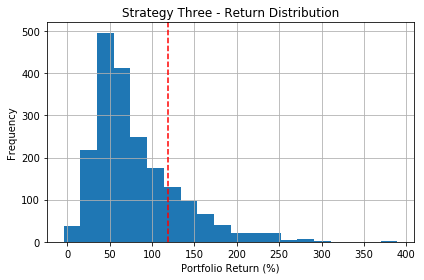

In [40]:
import statistics

print ("Strategy Three Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(6, 4))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy Three - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

# plt.xlim(left=-100, right=700)

plt.show()